In [21]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import importlib
import os
from sklearn.metrics import confusion_matrix
import config
importlib.reload(config)
from config import BIN_SIZE, STRATIFY_BY, ANALYSIS_MODE
import joblib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import get_stable_pipeline, preprocess_data

In [2]:
# Configuration
MODEL_PATH = 'simple_lasso_model.joblib'
FEATURES_PATH = 'model_features.joblib'
HOLDOUT_MATRIX_PATH = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/results/final_feature_matrix_gc_corrected_50000.tsv"
BIN_SIZE = 50000

print("--- Final Holdout Validation ---")

--- Final Holdout Validation ---


In [ ]:
model = joblib.load(MODEL_PATH)

# model_step = model.named_steps['stable_model']
# c_wert = model_step.C
# print(f"Der verwendete C-Wert ist: {c_wert}")


# Simple Pipeline
c_best = model.named_steps['lasso_cv'].C_[0] 
alle_cs = model.named_steps['lasso_cv'].Cs_
print(f"Bester C-Wert aus CV: {c_best}")

Bester C-Wert aus CV: 24.420530945486497


In [ ]:
# # 1. Die gesamte Struktur anzeigen
# print("Modell Struktur:")
# print(model)

# # 2. Nur das Modell innerhalb der Pipeline ansprechen (der letzte Schritt)
# model_step = model.named_steps['stable_model']

# # 3. Den C-Wert und andere Hyperparameter auslesen
# print("\n--- Modell Parameter ---")
# print(f"Gewählter C-Wert (c_1se): {model_step.C}")
# print(f"Penalty (Lasso/Ridge):   {model_step.penalty}")
# print(f"Solver:                  {model_step.solver}")

# # 4. Falls du sehen willst, wie viele Koeffizienten NICHT null sind (Relevante Bins)
# n_features = np.sum(model_step.coef_ != 0)
# print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")




# Simple Model

cv_step = model.named_steps['lasso_cv']

print("\n--- CV Modell Parameter ---")
print(f"Bester C-Wert (optimal): {cv_step.C_[0]}") 
print(f"Anzahl getesteter Cs:    {len(cv_step.Cs_)}")
print(f"Penalty:                 {cv_step.penalty}")

n_features = np.sum(cv_step.coef_ != 0)
model_features = joblib.load('model_features.joblib')

print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")
mean_scores = np.mean(cv_step.scores_[1], axis=0) 
best_score = np.max(mean_scores)
print(f"Bester Mean CV AUC:     {best_score:.4f}")

needed_metrics = list(set([f.split('_chr')[0] for f in model_features]))
print(f"Metrics required by model: {needed_metrics}")

CV Modell Struktur:
Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso_cv',
                 LogisticRegressionCV(Cs=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.963623...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                                      cv=5, max_iter=10000, penalty='l1',
                                      random_state=42, scoring='roc_auc',
                                      solver='liblinear'))])

--- CV Mod

In [12]:
# 3. Load Holdout Data
print("Loading holdout matrix...")
if not os.path.exists(HOLDOUT_MATRIX_PATH):
    print(f"ERROR: Holdout matrix not found at {HOLDOUT_MATRIX_PATH}")
    exit(1)

df_holdout = pd.read_csv(HOLDOUT_MATRIX_PATH, sep="\t")

Loading holdout matrix...


In [13]:
# 4. Prepare Holdout Features (Pivoting)
print("Formatting holdout features to match model structure...")
# Add bin_id (format chrom_start) like in your helper_functions
df_holdout["bin_id"] = df_holdout["chrom"] + "_" + df_holdout["start"].astype(str)

# Pivot the long-format holdout data into the wide format the model expects
X_holdout_raw = df_holdout.pivot(index="sample", columns="bin_id", values=needed_metrics)

# Flatten columns to match 'metric_chrom_start' (e.g., 'mean_chr1_900000')
X_holdout_raw.columns = [f"{m}_{bid}" for m, bid in X_holdout_raw.columns]

# IMPORTANT: Align columns with the model features (handle missing bins and order)
X_holdout = X_holdout_raw.reindex(columns=model_features, fill_value=0)
print(f"Feature alignment complete. Shape: {X_holdout.shape}")

Formatting holdout features to match model structure...
Feature alignment complete. Shape: (30, 12780)


In [14]:
# 5. Extract Ground Truth (y_holdout)
# We use the 'group' column which contains the folder names (healthy, pancreatic, etc.)
group_info = df_holdout[['sample', 'group']].drop_duplicates().set_index('sample')
# 1 if cancer, 0 if healthy
y_holdout = (group_info.loc[X_holdout.index, "group"].str.lower() != "healthy").astype(int).values


In [16]:
# 6. Prediction
print(f"Running prediction on {len(X_holdout)} samples...")
probs = model.predict_proba(X_holdout)[:, 1]

Running prediction on 30 samples...


In [17]:
# 7. Evaluation (AUC Score)
auc_score = roc_auc_score(y_holdout, probs)
print(f"\n" + "="*40)
print(f"FINAL HOLDOUT AUC: {auc_score:.4f}")
print("="*40 + "\n")


FINAL HOLDOUT AUC: 0.4756



In [18]:
# 8. Save Results
output_dir = "holdout_preprocessing/results"
os.makedirs(output_dir, exist_ok=True)
results_df = pd.DataFrame({
    'sample': X_holdout.index,
    'prediction_score': probs,
    'true_label': y_holdout
})
results_df.to_csv(f"{output_dir}/holdout_validation_results.csv", index=False)


Detailed results and plots saved in 'holdout_preprocessing/'.


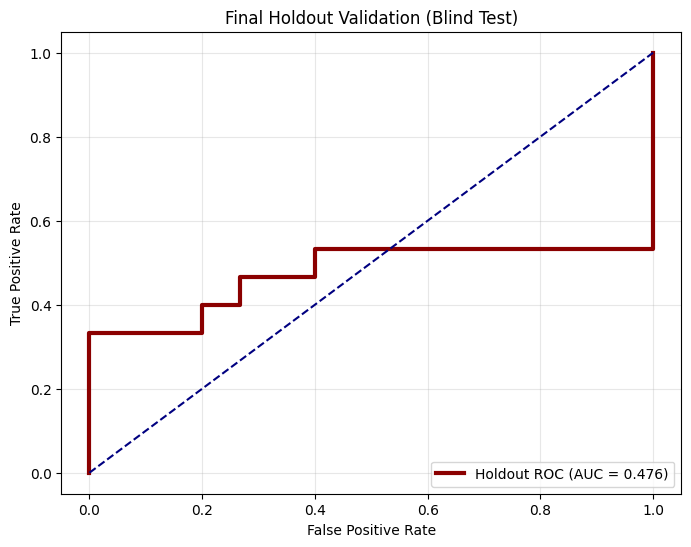

In [19]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=3, label=f'Holdout ROC (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Holdout Validation (Blind Test)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("holdout_preprocessing/plots/holdout_final_roc_joblib.png")
print("Detailed results and plots saved in 'holdout_preprocessing/'.")

In [22]:
# 5.5 DIAGNOSTIC: Check what's happening
print("="*80)
print("DIAGNOSTIC: Label & Prediction Analysis")
print("="*80)

preds = (probs > 0.5).astype(int)

print(f"\n1. Label Distribution:")
print(f"   0 (Healthy): {np.sum(y_holdout == 0)} samples")
print(f"   1 (Cancer):  {np.sum(y_holdout == 1)} samples")

print(f"\n2. Prediction Distribution:")
print(f"   0 (Predicted Healthy): {np.sum(preds == 0)} samples")
print(f"   1 (Predicted Cancer):  {np.sum(preds == 1)} samples")

print(f"\n3. Probability Statistics:")
print(f"   Min:    {probs.min():.4f}")
print(f"   Max:    {probs.max():.4f}")
print(f"   Mean:   {probs.mean():.4f}")
print(f"   Median: {np.median(probs):.4f}")

tn, fp, fn, tp = confusion_matrix(y_holdout, preds).ravel()
print(f"\n4. Confusion Matrix:")
print(f"   TP: {tp:2d}  FP: {fp:2d}")
print(f"   FN: {fn:2d}  TN: {tn:2d}")

print(f"\n5. Sample-by-Sample Breakdown:")
results_diag = pd.DataFrame({
    'sample': X_holdout.index,
    'group': group_info.loc[X_holdout.index, 'group'].values,
    'true_label': y_holdout,
    'prob_cancer': probs,
    'pred_label': preds
})
print(results_diag.sort_values('prob_cancer', ascending=False).to_string())

print(f"\n6. AUC Test - Check if labels are inverted:")
y_flipped = 1 - y_holdout
from sklearn.metrics import roc_auc_score
auc_flipped = roc_auc_score(y_flipped, probs)
print(f"   Current AUC:       {roc_auc_score(y_holdout, probs):.4f}")
print(f"   AUC with flipped labels: {auc_flipped:.4f}")
if auc_flipped > 0.8:
    print(f"   ⚠️  ALERT: Labels might be INVERTED! AUC improves to {auc_flipped:.4f}")

print("="*80)

DIAGNOSTIC: Label & Prediction Analysis

1. Label Distribution:
   0 (Healthy): 15 samples
   1 (Cancer):  15 samples

2. Prediction Distribution:
   0 (Predicted Healthy): 13 samples
   1 (Predicted Cancer):  17 samples

3. Probability Statistics:
   Min:    0.0000
   Max:    1.0000
   Mean:   0.5525
   Median: 0.6875

4. Confusion Matrix:
   TP:  8  FP:  9
   FN:  7  TN:  6

5. Sample-by-Sample Breakdown:
     sample       group  true_label   prob_cancer  pred_label
2   EE85726  colorectal           1  1.000000e+00           1
21  EE86253  esophageal           1  9.999990e-01           1
0   EE85723  colorectal           1  9.999946e-01           1
1   EE85724  colorectal           1  9.999517e-01           1
23  EE87786    bileduct           1  9.971728e-01           1
13  EE85842     healthy           0  9.905260e-01           1
4   EE85757     healthy           0  9.893258e-01           1
10  EE85795     healthy           0  9.837080e-01           1
24  EE87787    bileduct        